<a href="https://colab.research.google.com/github/agrawalnandini/Chatbot/blob/master/chatbot_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


#Setup

In [0]:
from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense, Bidirectional, GRU, Activation, dot, concatenate, Dropout
from keras.models import Model, load_model
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

import pickle
import sys
import os
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
import tensorflow as tf
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
     raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
INPUT_LENGTH = 20
OUTPUT_LENGTH = 20 
NUM_SAMPLES = 40000
EMBEDDING_DIM = 100

In [0]:
#MOUNTING GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading & Cleaning Data

In [0]:
lines_path = '/content/drive/My Drive/movie_lines.txt'
conv_path = '/content/drive/My Drive/movie_conversations.txt'
glove_path = '/content/drive/My Drive/glove.twitter.27B.100d.txt'

In [0]:
# READING DATA

lines = open(lines_path, encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open(conv_path, encoding='utf-8', errors='ignore').read().split('\n')

lineID = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        #use line index as an index to the dialog (which is the 5th element)
        lineID[_line[0]] = _line[4]

convs = [ ]
for line in conv_lines[:-1]:
    #replacing cause of utf-8 error and removing spaces
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    #appending the array of dialogs for the given conversation
    convs.append(_line.split(','))

In [0]:
# SHUFFLING, SAMPLING DATA & SPLITTING INTO CONTEXT AND RESPONSE FOR TRAINING

questions = []
responses = []
for conv in convs:
    for i in range(len(conv)-1):
        questions.append(lineID[conv[i]])
        responses.append(lineID[conv[i+1]])

    
pairs=list(zip(questions,responses))
random.shuffle(pairs)
questions, responses=list(zip(*pairs))   

In [0]:

# REPLACING CONTRACTIONS AND REMOVING SPECIAL SYMBOLS AND MAKING INTO LOWER CASE

def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|]", "", text)
    text = " ".join(text.split())
    return text

In [0]:
# ADDING DATA TO LIST AFTER CLEANING

clean_questions = []
clean_responses = []    

for i in range(len(questions)):
    clean_questions.append(clean_text(questions[i]))
    clean_responses.append(clean_text(responses[i]))

In [0]:
# REMOVING CONTEXT AND RESPONSE >= MAX_LIN_LEN AND <= MIN_LIN_LEN

min_line_len = 2
max_line_len = 18

questions_final = []
responses_final = []
for i in range(len(clean_questions)):
    if (len(clean_questions[i].split())>=min_line_len and len(clean_responses[i].split())>=min_line_len 
        and len(clean_questions[i].split())<=max_line_len and len(clean_responses[i].split())<=max_line_len):
            
        questions_final.append(clean_questions[i])
        responses_final.append(clean_responses[i])


In [0]:
# SAMPLING DATA; LIMITED TO 40000 PAIRS DUE TO MEMORY CONSTRAINTS

pairs=list(zip(questions_final,responses_final))
pairs = pairs[:NUM_SAMPLES]
questions_final, responses_final=list(zip(*pairs)) 

In [0]:
len(responses_final)

40000

#Preprocessing

In [0]:
# def save_obj(obj, name ):
#     with open(name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# def load_obj(name ):
#     with open(name + '.pkl', 'rb') as f:
#         return pickle.load(f)

In [0]:
# SPLITTING SENTENCES TO WORDS
questions_final_tok=[]
responses_final_tok=[]

for i in range(0,NUM_SAMPLES):
    questions_final_tok.append(nltk.word_tokenize(questions_final[i]))
    responses_final_tok.append(nltk.word_tokenize(responses_final[i]))

In [0]:
# CREATING A DICTIONARY WITH WORD FREQUENCY

vocab = {}
for sentence in questions_final_tok + responses_final_tok:
    for word in sentence:
        if word in vocab:
            vocab[word] += 1
        else:
            vocab[word] = 1

In [0]:
PADDING_ENCODING = 0
START_ENCODING = 1
index = 2
rare_word_limit = 10

In [0]:
# CREATING MAPPINGS FOR WORDS; FOR REPRESENTING WORDS AS NUMERIC VALUES 

word_to_idx = {} 
idx_to_word = {1: '<START>'} 

for word, count in vocab.items():
    if (count >= rare_word_limit): 
        word_to_idx[word] = index 
        idx_to_word[index] = word
        index += 1  

In [0]:
# ADDING RARE WORDS TO MAPPINGS AS <UNK>

num_unique_words = len(word_to_idx)
idx_to_word[num_unique_words + 2] = '<UNK>'
word_to_idx['<UNK>'] = len(word_to_idx)+2

In [0]:
# SIZE OF DICTIONARY WILL BE NUMBER OF UNIQUE WORDS + 1 FOR UNK

dict_size = index + 1

In [0]:
dict_size

3133

In [0]:
print(vocab)

{'look': 1095, 'i': 27520, 'got': 2378, 'ta': 369, 'get': 2620, 'going': 1655, ',': 29672, 'should': 838, 'not': 15283, 'you': 30423, 'have': 6014, 'met': 125, 'katka': 4, '?': 27915, 'hey': 571, 'ray': 60, 'what': 8801, 'is': 15650, 'the': 15623, 'name': 519, 'of': 5802, 'that': 8629, 'nightclub': 3, 'yours': 134, 'she': 2337, 'fine': 476, 'charles': 36, '.': 69688, 'take': 1008, 'it': 12783, 'easy': 174, '...': 10508, 'girls': 92, 'seen': 297, 'a': 11628, 'brown': 32, 'bag': 47, 'with': 2736, 'white': 104, 'stripe': 5, 'and': 5338, 'my': 3725, 'initials': 2, 'huh': 349, 'no': 4155, 'are': 8138, 'ginait': 1, 'everybody': 153, 'else': 365, 'who': 1550, 'bonkers': 1, '!': 8085, 'small': 67, 'bed': 125, 'maybe': 751, 'sleep': 160, 'in': 5204, 'barn': 6, 'carl': 35, 'howard': 9, 'hunt': 19, 'jesus': 184, 'christ': 130, 'open': 188, 'up': 1928, 'scab': 3, 'uncover': 3, 'lot': 331, 'pus': 1, 'do': 10188, 'ah': 113, 'film': 32, 'called': 230, "'slave": 2, 'love': 588, "'": 1633, 'would': 282

In [0]:
# FUNCTION TO ENCODE WORDS TO NUM USING THE MAPPINGS CREATED
def encode_to_idx(data):
  DIM = INPUT_LENGTH
  encoded_input = np.zeros(shape=(len(data), DIM))
  for i in range(len(data)):
    for j in range(min(len(data[i]), DIM)):
      try:
        encoded_input[i][j] = word_to_idx[data[i][j]]
      except:
        encoded_input[i][j] = word_to_idx['<UNK>']
  return encoded_input

In [0]:
# SPLITTING INTO TRAIN + VALIDATION SETS

training_input, validation_input, training_output, validation_output = train_test_split(questions_final_tok, responses_final_tok, test_size=0.2, random_state=1)
training_input  = [tr_input[::-1] for tr_input in training_input] 
# validation_input  = [val_input[::-1] for val_input in validation_input]

In [0]:
# CALLING FUNCTION TO ENCODE

final_training_input = encode_to_idx(training_input)
final_training_output = encode_to_idx(training_output)

# final_validation_input = encode_to_idx(word_to_idx, validation_input)
# final_validation_output = encode_to_idx(word_to_idx, validation_output)

In [0]:
# READING GLOVE VECTOR PRETRAINED MODEL

# read in the EMBEDDING_DIM dimensional GloVe embeddings
#making lists of words in the Glove file and its word_to_vec embedding
def read_glove_vecs(file):
    with open(file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        
        for line in f:
            line = line.strip().split()
            word = line[0]
            words.add(word)
            word_to_vec_map[word] = np.array(line[1:], dtype=np.float64)
            
    return words, word_to_vec_map

words, word_to_vec_map = read_glove_vecs(glove_path)

In [0]:
len(final_training_input)

32000

In [0]:
# FORMING EMBEDDING MATRIX BASED ON OUR DATA AND THE GLOVE VECTORS

# since the indexes start from 1 and not 0, we add 1 to the no. of total words to get the vocabulary size (while initializing 
# initialize the embedding matrix that will be used (EMBEDDING_DIM is the GloVe vector dimension)
embedding_matrix = np.zeros((dict_size, EMBEDDING_DIM))
for word, index in word_to_idx.items():
    try:
        embedding_matrix[index, :] = word_to_vec_map[word.lower()]
    except: continue

In [0]:
# PREPARING DATA FOR MODEL

training_encoder_input = final_training_input
training_decoder_input = np.zeros_like(final_training_output)
training_decoder_input[:, 1:] = final_training_output[:,:-1]
training_decoder_input[:, 0] = START_ENCODING
training_decoder_output = np.eye(dict_size)[final_training_output.astype('int')]

# validation_encoder_input = final_validation_input
# validation_decoder_input = np.zeros_like(final_validation_output)
# validation_decoder_input[:, 1:] = final_validation_output[:,:-1]
# validation_decoder_input[:, 0] = START_ENCODING
# validation_decoder_output = np.eye(dict_size)[final_validation_output.astype('int')]

# Model

In [0]:
BATCH_SIZE = 64
EPOCHS = 30

In [0]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

In [0]:
from keras.regularizers import l2
embed_layer = Embedding(dict_size, EMBEDDING_DIM, input_length=INPUT_LENGTH, mask_zero=True) #, weights = [embedding_matrix])
encoder = embed_layer(encoder_input)
encoder = Bidirectional(LSTM(256,return_sequences=True, unroll=True))(encoder)
encoder = Dropout(0.2)(encoder)
encoder_last = encoder[:,-1,:]

embed_layer = Embedding(dict_size, EMBEDDING_DIM, input_length=OUTPUT_LENGTH, mask_zero=True,weights=[embedding_matrix])
decoder = embed_layer(decoder_input)
decoder = LSTM(512, recurrent_regularizer=l2(0.01),return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last,encoder_last])

attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
context = dot([attention, encoder], axes=[2,1])

decoder_combined_context = concatenate([context, decoder])

output = TimeDistributed(Dense(512, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(dict_size, activation="softmax"))(output)

In [0]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam' , loss='categorical_crossentropy', metrics = ['accuracy'])

In [0]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 20, 100)      313300      input_15[0][0]                   
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 20, 100)      313300      input_16[0][0]                   
____________________________________________________________________________________________

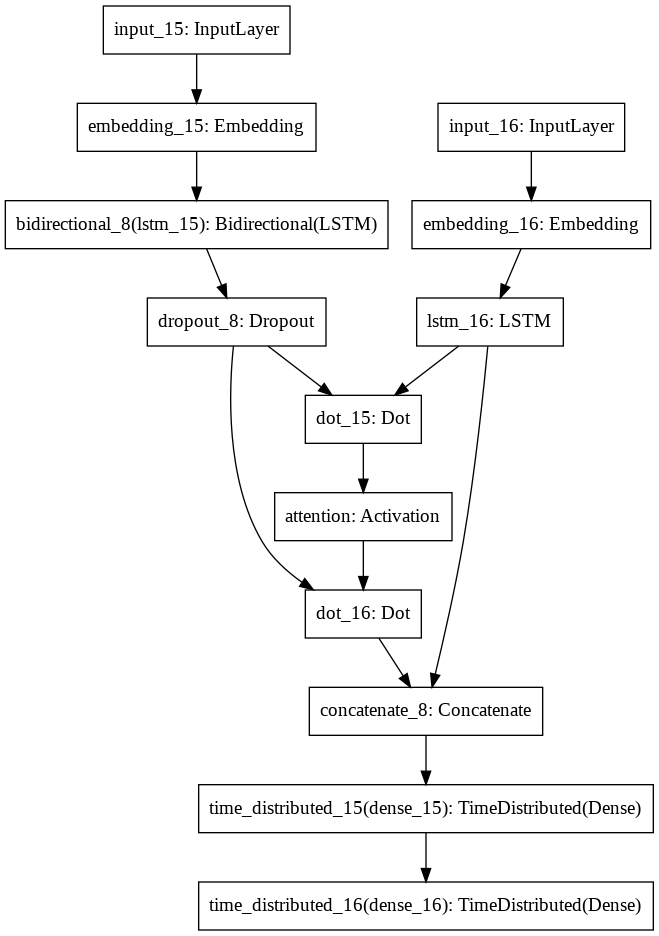

In [0]:
plot_model(model)

In [0]:
len(training_encoder_input)

32000

In [0]:
model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],batch_size=BATCH_SIZE, epochs=30)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
32000/32000 [==============================] - 36s 1ms/step - loss: 2.4096 - accuracy: 0.2519
Epoch 2/30
32000/32000 [==============================] - 32s 989us/step - loss: 1.9836 - accuracy: 0.3028
Epoch 3/30
32000/32000 [==============================] - 32s 996us/step - loss: 1.9018 - accuracy: 0.3142
Epoch 4/30
32000/32000 [==============================] - 32s 989us/step - loss: 1.8428 - accuracy: 0.3227
Epoch 5/30
32000/32000 [==============================] - 32s 986us/step - loss: 1.7907 - accuracy: 0.3297
Epoch 6/30
32000/32000 [==============================] - 32s 989us/step - loss: 1.7415 - accuracy: 0.3358
Epoch 7/30
32000/32000 [==============================] - 32s 985us/step - loss: 1.6924 - accuracy: 0.3429
Epoch 8/30
32000/32000 [==============================] - 32s 989us/step - loss: 1.6403 - accuracy: 0.3514
Epoch 9/30
32000/32000 [==============================] - 31s 981us/step - loss: 1.5870 - accuracy: 0.3602
Epoch 10/30
32000/32000 [==============

In [0]:
#model.save_weights('/content/drive/My Drive/model_attention_weights.h5')

# Prediction & Testing

In [0]:
# model.load_weights("/content/drive/My Drive/model_attention_weights.h5")
# word_to_idx=load_obj("wordidx")
# idx_to_word=load_obj("idxword")
# vocab=load_obj(vocab,"vocab")

In [0]:
# PREDICTING FROM GIVEN INPUT

def test_on_input(raw_input):
    #clean_input = clean_text(raw_input)
    #input_tokens = [nltk.word_tokenize(clean_input)]
    input_tokens = [raw_input[0][::-1]]
    encoder_input = encode_to_idx(input_tokens)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = START_ENCODING

    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return output

In [0]:
# PREDICTING FROM GIVEN INPUT

def chat_with_bot(raw_input):
    clean_input = clean_text(raw_input)
    input_tokens = [nltk.word_tokenize(clean_input)]
    input_tokens = [input_tokens[0][::-1]]
    encoder_input = encode_to_idx(input_tokens)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = START_ENCODING

    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return output

In [0]:
# FUNCTION TO DECODE VECTOR REPRESENTATION OF OUTPUT

def decode(vector_representation):
    text = ''
    for i in vector_representation:
        if i == 0:
            break
        text += ' '
        text += idx_to_word[i]
    return text

In [0]:
def join_tokens(token_list):
  statement=' '.join(token_list)
  return statement

In [0]:
for i in range(720,730):
  question=validation_input[i]
  output=test_on_input(question)
  decoded_output=decode(output[0])
  print("Context: ",join_tokens(validation_input[i]))
  print("Predicted: ",decoded_output)
  print("Actual: ",join_tokens(validation_output[i]))
  

Context:  hey , sport . how are things ?
Predicted:   it was you , your majesty .
Actual:  o.k. , cowboy .
Context:  you do not know ? she left thirty minutes ago .
Predicted:   he was not <UNK> that you were wearing !
Actual:  where would she go ?
Context:  what are they going to do ?
Predicted:   that is right .
Actual:  do you always wear your hair like that ?
Context:  maybe i do .
Predicted:   jon ? whom ? whom ? how they are they ?
Actual:  maybe i do not need your ideas . maybe i can do better on my own .
Context:  joey , what is more important , the kids ' clothes or your sexual potency .
Predicted:   you ever <UNK> him .
Actual:  i do not want to hear that word !
Context:  what was her name ?
Predicted:   that is right .
Actual:  camila . camila valencias .
Context:  and he can arrange for the porters to take us back ?
Predicted:   only one word for a <UNK> ?
Actual:  the high lama arranges everything , mr. conway .
Context:  angie . he says she was a real scrawny looking thin

In [0]:
#CHATTING WITH 
#encode_to_idx, cleantext,word_to_idx
while True:
  question=input()
  output = chat_with_bot(question)
  decoded_output = decode(output[0])
  print (decoded_output)

hi
 hi , david .
how are you?
 i am tired .
where are you?
 i am everywhere .
what are you doing?
 i am a <UNK> .
i see
 yeah . but i think it is a fact .
i agree
 i wish i could not tell you .
it is okay
 i have to go home and work .
okay
 yeah . definitely .
okay bye
 unless ya wan na get breakfast .
sure i dont mind
 you are not going to destroy it .
thank you
 i have been <UNK> my lunch hour . i will get you through the <UNK> .
fuck you
 no , it is just ... it is a <UNK> you got ta do it .
